## Calculating Global Coherence

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate [global coherence](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.global_coherence) between insolation and oxygen isotopes from our set of records.

The notebook is structured as follows:

1. Define a function that will be used to calculate correlations between records that contain large hiatuses
2. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
3. Calculate correlation between insolation and records to find most correlated latitude of insolation
4. Calculate global coherence between insolation at the most correlated latitude and each record
5. Plot results

In [1]:
# Importing libraries

import pickle
from tqdm import tqdm

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

This function was first defined in the Toy Data Heuristic notebook, look there for more notes.

In [ ]:
def correlate_hiatus_series(series1, series2, cutoff_scale1=None):
    """Function to correlate series with large gaps. This is done by segmenting the time series, smoothing (if this is desired),
    and then reconnecting the time series with a dummy time axis so as not to re-introduce the hiatuses.

    series1 : pyleoclim.Series
        One series to correlate, presumed to have hiatuses
    series2 : pyleoclim.Series
        Other series to correlate, presumed to not have hiatuses
    cutoff_scale : int
        Cutoff scale for smoothing for series 1
    """

    if cutoff_scale1:
        segments = series1.segment()
        if isinstance(segments, pyleo.core.multiplegeoseries.MultipleGeoSeries):
            smoothed_series_value = []
            smoothed_series_time = []
            for segment in segments.series_list:
                if max(segment.time) - min(segment.time) > 6:
                    segment_smooth = segment.interp().filter(cutoff_scale=cutoff_scale1)
                    smoothed_series_value.extend(segment_smooth.value)
                    smoothed_series_time.extend(segment_smooth.time)
            smoothed_series = series1.copy()
            smoothed_series.value = smoothed_series_value
            smoothed_series.time = smoothed_series_time
        else:
            smoothed_series = series1.interp().filter(cutoff_scale=cutoff_scale1)
        series1 = smoothed_series

    smoothed_segments = series1.segment()
    series1_values = []
    series2_values = []
    if isinstance(smoothed_segments, pyleo.core.multiplegeoseries.MultipleGeoSeries):
        for segment in smoothed_segments.series_list:
            ms = pyleo.MultipleSeries([segment, series2]).common_time()
            s1, s2 = ms.series_list
            series1_values.extend(s1.value)
            series2_values.extend(s2.value)
        assert len(series1_values) == len(series2_values)
        time = np.arange(len(series1_values))
        s1_corr = pyleo.Series(
            time=np.array(time), value=np.array(series1_values), verbose=False
        )
        s2_corr = pyleo.Series(
            time=np.array(time), value=np.array(series2_values), verbose=False
        )
    else:
        s1_corr = series1
        s2_corr = series2

    # Normally this isn't necessary, just dealing with a bug in the pyleoclim library
    s1_corr.time = np.array(s1_corr.time)
    s1_corr.value = np.array(s1_corr.value)
    s2_corr.time = np.array(s2_corr.time)
    s2_corr.value = np.array(s2_corr.value)

    corr = s1_corr.correlation(s2_corr, number=1, mute_pbar=True)

    return corr

In [ ]:
# Importing the data

with open("../../data/geo_ms_composite_dict.pkl", "rb") as handle:
    geo_ms_composite_dict = pickle.load(handle)

Creating integrated insolation curve at northern hemisphere latitudes and southern hemisphere latitudes over the respective summer months:

In [ ]:
# Creating a dictionary with the insolation data for each latitude

lat_list = np.arange(-80, 85, 5)
jja_dict = {}
djf_dict = {}

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

# Day numbers from June 1st to August 31st
jja_days = np.arange(152, 243)

# Day numbers from December 1st to January 31st
djf_days1 = np.arange(335, 365)
djf_days2 = np.arange(0, 60)
djf_days = np.concatenate((djf_days1, djf_days2))

for lat in lat_list:
    if lat > 0:
        days = jja_days
        inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim="day")
        inso_series = pyleo.Series(
            time=0 - years[::-1],
            value=inso[::-1],
            time_name="Age",
            time_unit="Kyr BP",
            value_name=f"JJA Insolation {lat} N",
            value_unit="W/m^2",
            verbose=False,
            label="Insolation",
        )
        jja_dict[lat] = inso_series
    elif lat < 0:
        days = djf_days
        inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim="day")
        inso_series = pyleo.Series(
            time=0 - years[::-1],
            value=inso[::-1],
            time_name="Age",
            time_unit="Kyr BP",
            value_name=f"DJF Insolation {-lat} S",
            value_unit="W/m^2",
            verbose=False,
            label="Insolation",
        )
        djf_dict[lat] = inso_series
    else:
        continue

Calculating the most correlated latitude of integrated summer insolation in each record's respective hemisphere for usage in global coherence analysis:

In [ ]:
# Calculate the most correlated latitude

num_records = len(geo_ms_composite_dict)
palette = sns.color_palette("colorblind", num_records)
segment_series_dict = {}

correlated_inso = {}
correlated_latitude = {}

for idx, series in enumerate(geo_ms_composite_dict.values()):
    series = series.convert_time_unit("kyr BP").flip()
    lat = series.lat

    corr_res = {}
    if lat > 0:
        for corr_lat, corr_series in jja_dict.items():
            corr_list = []
            corr = correlate_hiatus_series(
                series1=series, series2=corr_series, cutoff_scale1=5
            )
            corr_res[corr_lat] = [corr.p, corr.r]

    elif lat < 0:
        for corr_lat, corr_series in djf_dict.items():
            corr_list = []
            corr = correlate_hiatus_series(
                series1=series, series2=corr_series, cutoff_scale1=5
            )
            corr_res[corr_lat] = [corr.p, corr.r]

    correlated_inso[series.label] = []

    r = 0
    for corr_lat, res in corr_res.items():
        corr_p, corr_r = res
        correlated_inso[series.label].append([corr_lat, corr_p, corr_r])
        if np.abs(np.mean(corr_r)) > r:
            r = corr_r
            correlated_latitude[series.label] = corr_lat

with open("../../data/correlated_latitude.pkl", "wb") as handle:
    pickle.dump(correlated_latitude, handle)

Calculating global coherence between insolation at the most correlated latitude and oxygen isotope data from each record:

In [ ]:
coherence_dict = {}

for series in tqdm(geo_ms_composite_dict.values()):
    label = series.label
    lat = correlated_latitude[label]
    series = series.standardize().convert_time_unit("kyr bp")

    if lat > 0:
        coherence_dict[series.label] = (
            jja_dict[lat]
            .slice((min(series.time), max(series.time)))
            .global_coherence(series, method="wwz")
        )  # .signif_test(method='phaseran',qs=[.8])
    elif lat < 0:
        coherence_dict[series.label] = (
            djf_dict[lat]
            .slice((min(series.time), max(series.time)))
            .global_coherence(series, method="wwz")
        )  # .signif_test(method='phaseran',qs=[.8])

100%|██████████| 14/14 [00:00<00:00, 92.47it/s]


In [ ]:
with open("../../data/cmap_grouped.pkl", "rb") as handle:
    cmap = pickle.load(handle)

with open("../../data/smooth_plotting_series_dict.pkl", "rb") as handle:
    smoothed_series_dict = pickle.load(handle)

Plotting results:

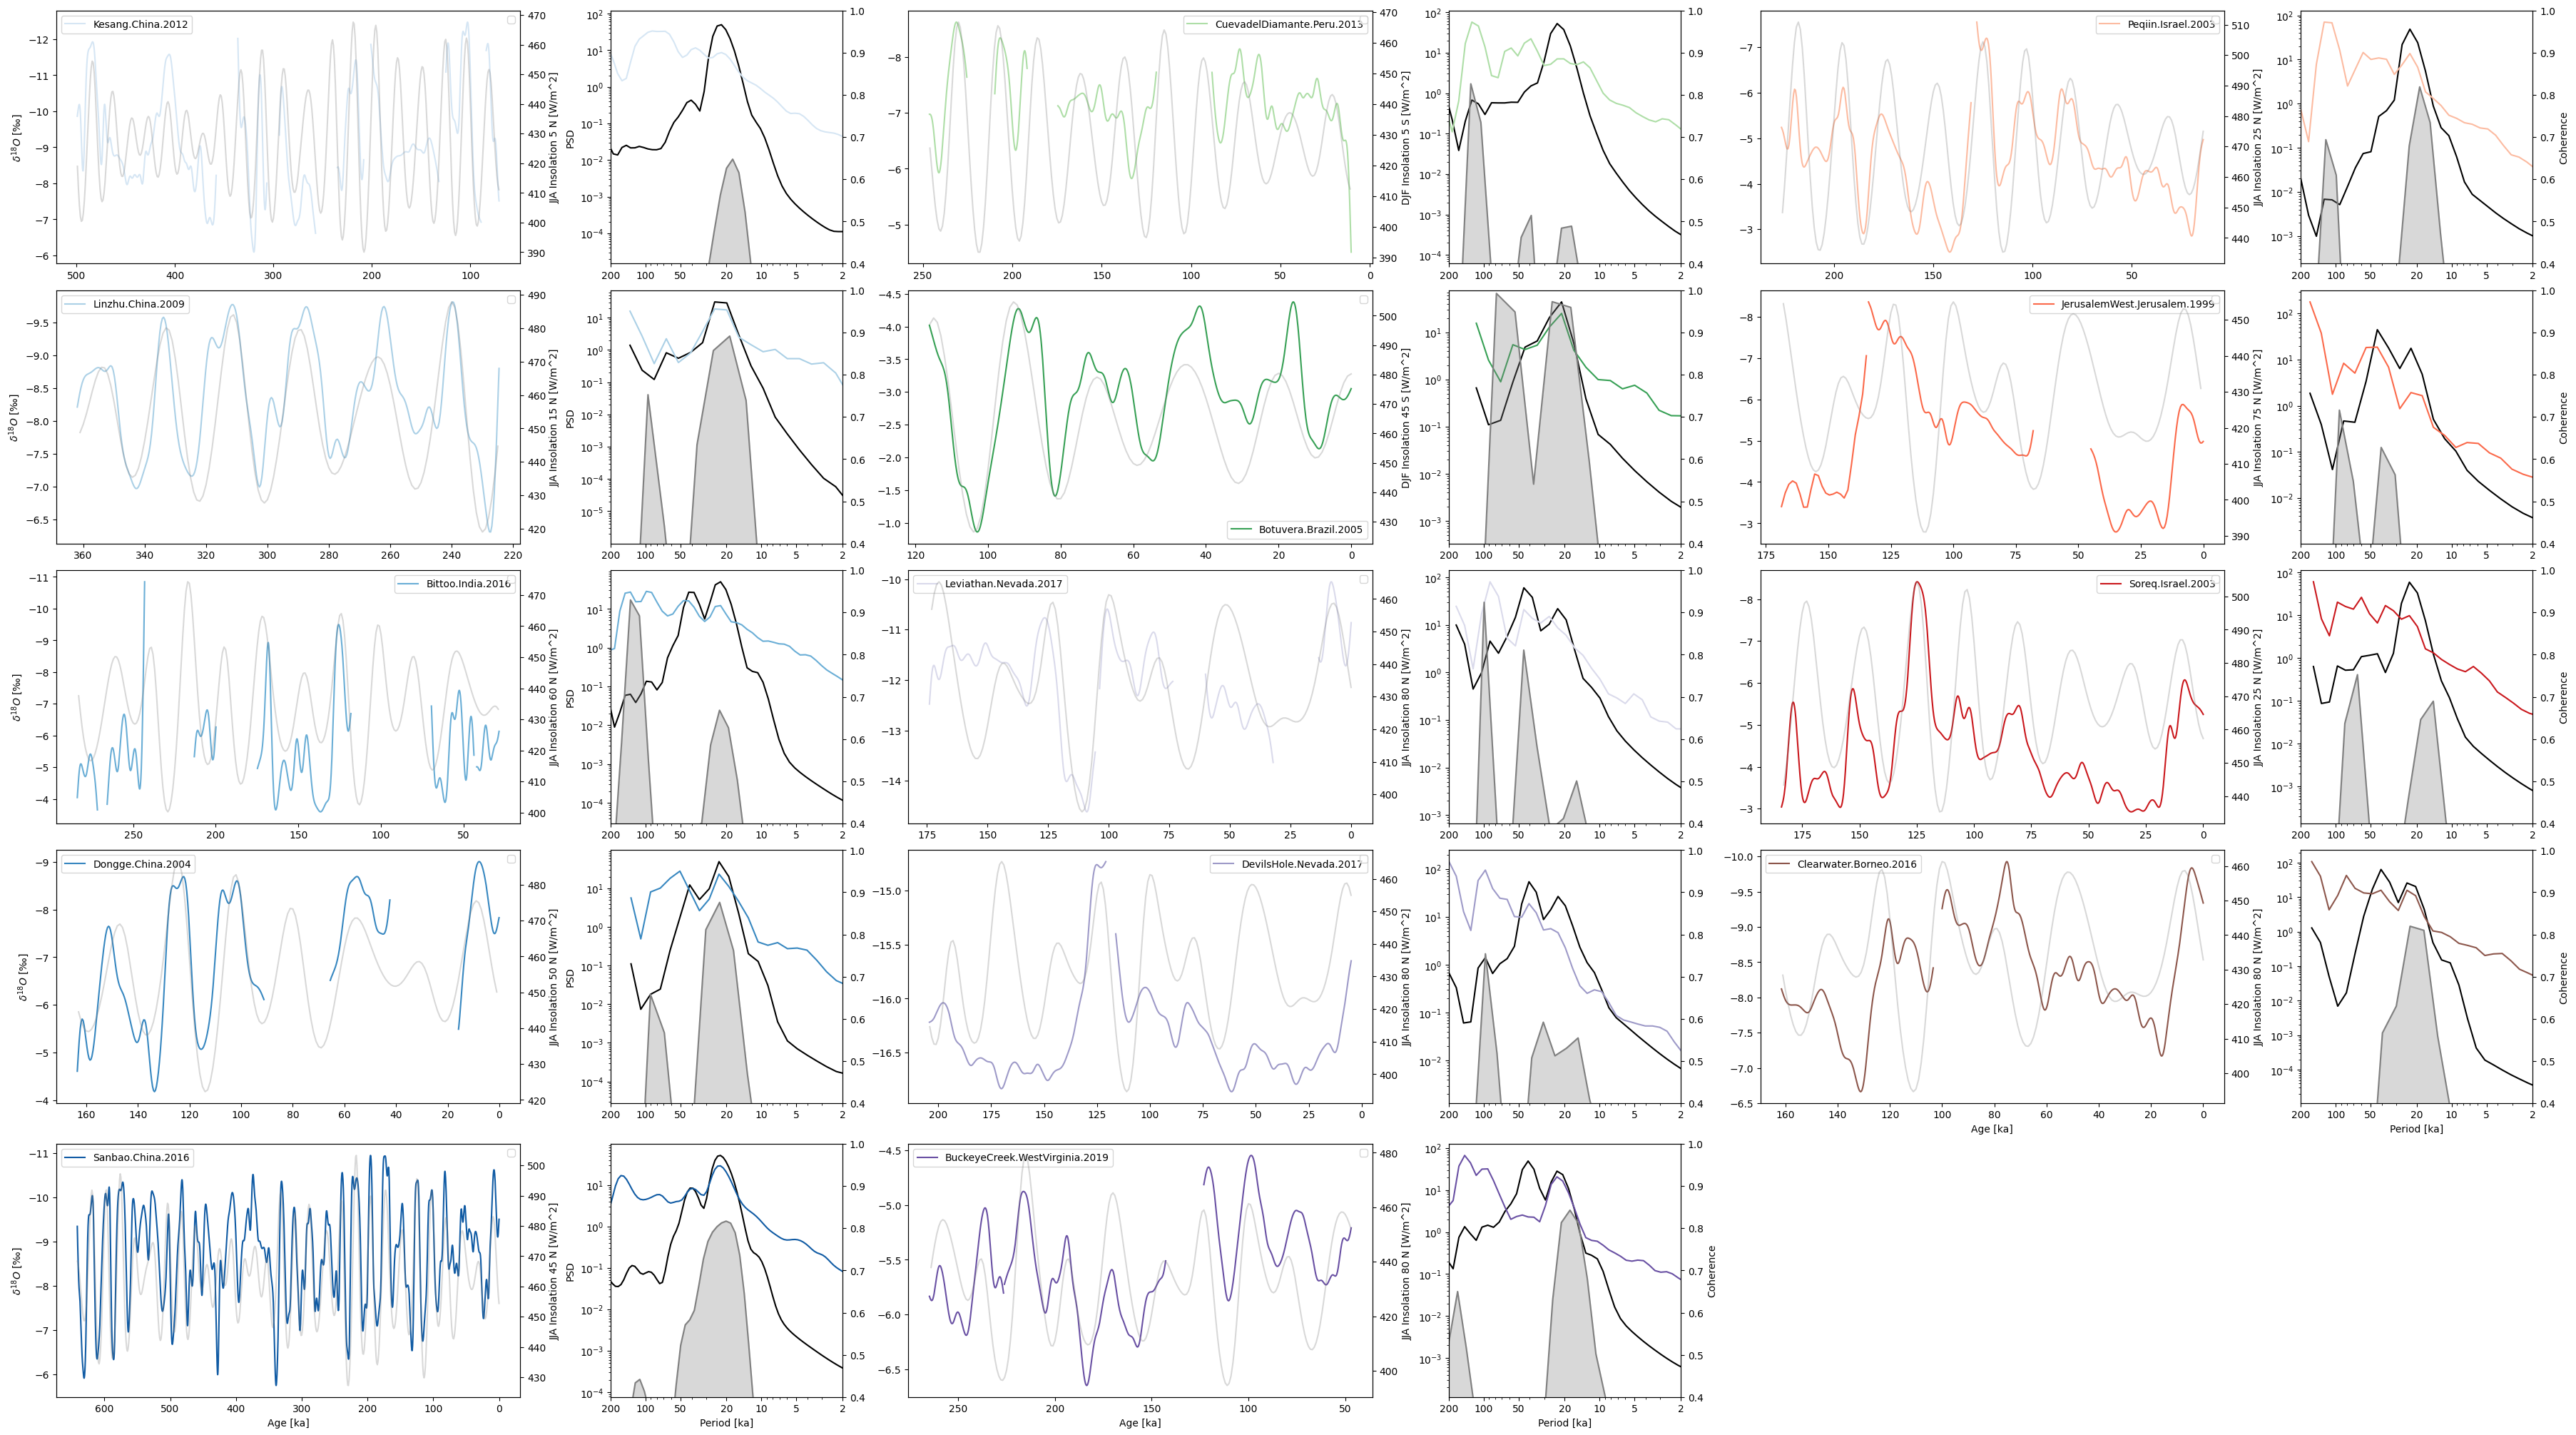

In [ ]:
fig = plt.figure(layout="constrained", figsize=(36, 20))
gs = GridSpec(nrows=5, ncols=9, figure=fig)

series_dict = {series.label: series for series in geo_ms_composite_dict.values()}
coherence_dict = {label: coherence_dict[label] for label in cmap.keys()}  # reordering

for idx, pair in enumerate(coherence_dict.items()):

    if idx <= 4:
        ax1 = fig.add_subplot(gs[idx, :2])
        ax2 = fig.add_subplot(gs[idx, 2])
    elif 4 < idx <= 9:
        ax1 = fig.add_subplot(gs[idx - 5, 3:5])
        ax2 = fig.add_subplot(gs[idx - 5, 5])
    elif 9 < idx <= 13:
        ax1 = fig.add_subplot(gs[idx - 10, 6:8])
        ax2 = fig.add_subplot(gs[idx - 10, 8])

    label, coh = pair
    lat = correlated_latitude[label]

    series = smoothed_series_dict[label].convert_time_unit("kyr BP")

    series.plot(ax=ax1, color=cmap[label], label=label, legend=True)
    ax1.legend().set_visible(True)
    ax1.invert_xaxis()
    if label not in [
        "DevilsHole.Nevada.2017",
        "BuckeyeCreek.WestVirginia.2019",
        "Leviathan.Nevada.2017",
    ]:
        ax1.invert_yaxis()

    twin_ax = ax1.twinx()
    if lat > 0:
        jja_dict[lat].slice((min(series.time), max(series.time))).plot(
            ax=twin_ax, color="grey", alpha=0.3, label=""
        )
    elif lat < 0:
        djf_dict[lat].slice((min(series.time), max(series.time))).plot(
            ax=twin_ax, color="grey", alpha=0.3, label=""
        )
    if idx in [9, 10, 11, 12, 13]:
        coh_y_label = "Coherence"
    else:
        coh_y_label = ""

    coh.plot(
        ax=ax2,
        coh_line_color="grey",
        fill_color="grey",
        spec1_plot_kwargs={"color": "black"},
        spec2_plot_kwargs={"color": cmap[label]},
        legend=False,
        coh_y_label=coh_y_label,
        xlim=(200, 0),
    )

    ax2.set_xlim(200, 0)
    ax2.set_xticks([200, 100, 50, 20, 10, 5, 2])

    if idx in [5, 6, 7, 8, 9, 10, 11, 12, 13]:
        ax1.set_ylabel("")
        ax2.set_ylabel("")
    if idx in [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12]:
        ax1.set_xlabel("")
        twin_ax.set_xlabel("")
        ax2.set_xlabel("")

    twin_ax.grid(False)
    ax1.grid(False)
    ax2.grid(False)